### Importing Jupyter notbook packages

In [16]:
# import python packages
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import itertools

%load_ext autoreload
%autoreload 2
import linear_regression as r
import data_cleaning as dc
import visualizations as vz
import modeling as m

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Read graduate admissions dataset and Train Test Split

*Source* https://www.kaggle.com/mohansacharya/graduate-admissions/downloads/graduate-admissions.zip/2

In [17]:
admissions_dataset = dc.import_admissions_dataset()

X = admissions_dataset.drop(columns=['Serial_No','Research','Chance_of_Admit'])
y = admissions_dataset[['Chance_of_Admit']]
X_train, X_test, y_train, y_test =  r.train_test_split_fxn(X, y, random_state = 12345, test_size = .2)
print("X_train: {}, X_test: {}, y_train: {}, y_test: {}".format(X_train.shape, X_test.shape, y_train.shape, y_test.shape))

X_train: (400, 6), X_test: (100, 6), y_train: (400, 1), y_test: (100, 1)


## Explore data (individual parameters)

In [18]:
sns.set_context("notebook")

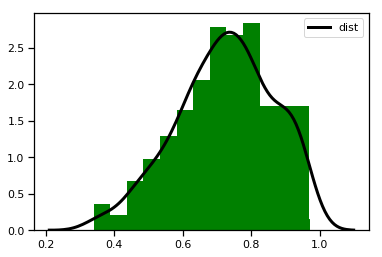

In [19]:
sns.distplot(y_train, rug=True, rug_kws={'color': 'g'},
             kde_kws={'color': 'k', 'lw': 3, 'label':'dist'},
             hist_kws = {'linewidth': 3, 'alpha': 1, 'color': 'g'})
plt.savefig('img/target_distribution')
plt.show()

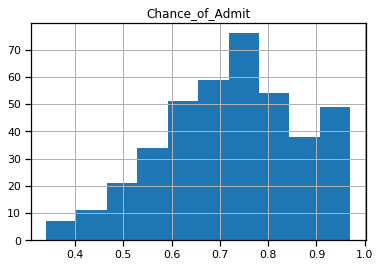

,Chance_of_Admit
count,400.000000
mean,0.724175
std,0.140564
min,0.340000
25%,0.637500
50%,0.730000
75%,0.820000
max,0.970000


In [20]:
y_train.hist()
plt.show()
y_train.describe()

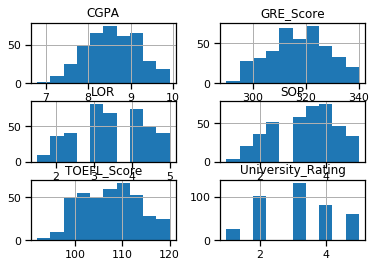

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA
count,400.000000,400.000000,400.000000,400.000000,400.000000,400.000000
mean,316.727500,107.335000,3.112500,3.375000,3.480000,8.580750
std,10.969232,6.091432,1.145917,0.987072,0.921533,0.601328
min,290.000000,92.000000,1.000000,1.000000,1.500000,6.800000
25%,309.000000,103.000000,2.000000,2.500000,3.000000,8.137500
50%,317.000000,107.000000,3.000000,3.500000,3.500000,8.565000
75%,324.250000,112.000000,4.000000,4.000000,4.000000,9.040000
max,340.000000,120.000000,5.000000,5.000000,5.000000,9.920000


In [21]:
X_train.hist()
plt.show()
X_train.describe()

## Explore data relationships

**Observations regarding pair plot:**
- **features~features:** we notice potentially linear relationships between various GRE Score, TOEFL score and CGPA categorical features (University ranking, SOP, LOR) also seem to be correlated with other variables
- **target~features:** target seems to be correlated with all feautres. There may be a non-linear relationship with GRE, TOEFL and GRE scores

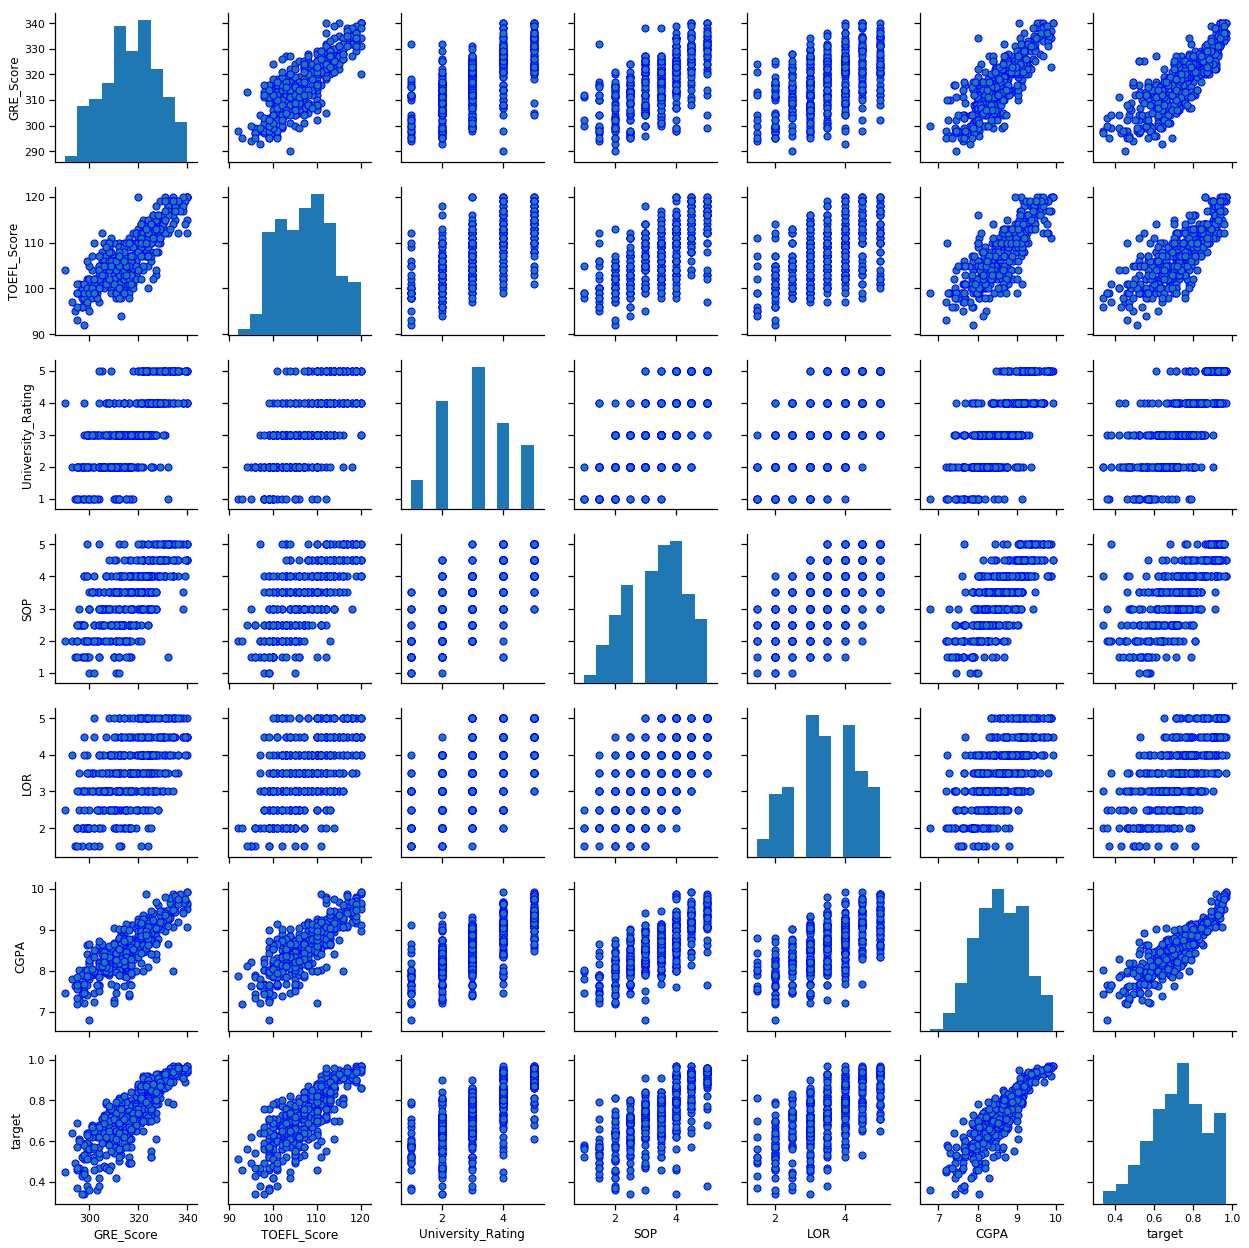

In [22]:
#create a temporary full dataset including target and features for visualization of potential trends
temp_full_df = X_train.copy()
temp_full_df['target'] = y_train

# plt.figure(figsize=(15,15))
pairplot = sns.pairplot(temp_full_df,
            plot_kws=dict(s=50, edgecolor="b", linewidth=1))

plt.savefig('img/pairplot_all.png')
plt.show()

**Observations regarding heatmap:**
 - **features~features:** various features are corellated with one another - the highest correlation amonst features is between CGPA and GRE score (0.82). For the time being we keep all features as our number of features (6) remains reasonable for the purposes of student selection and we aim to achieve a high (close to 1) R2
 - **target~features:** target seems to be most correlated with CGPA, GRE score, then TOEFL

In [23]:
def get_heatmap(df,savefig=False,save_path=False):
    """
    style options in order of size: paper, notebook, talk, poster
    style option not working at present
    """
    plt.figure(figsize=(15,7))
    sns.heatmap(df.corr(),annot = True)
    #should be able to change 
#     plt.style.use(style)
    if savefig:
        if save_path:
            plt.savefig(save_path,bbox_inches="tight")
        else:
            print("please specify path for saving")

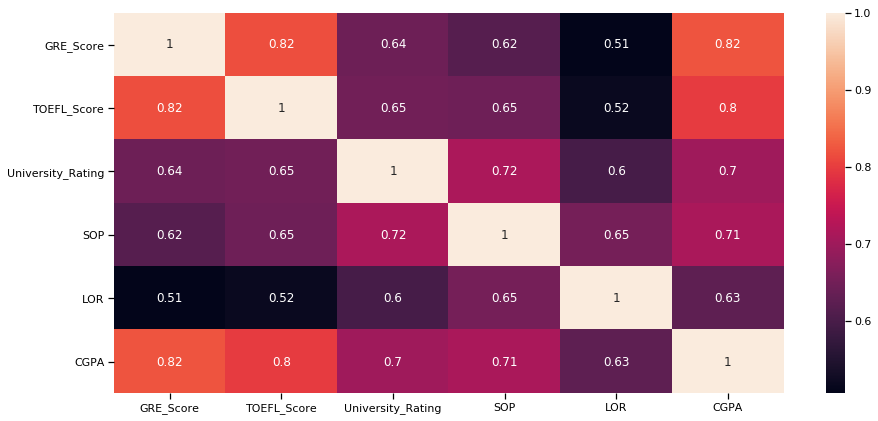

In [24]:
# get_heatmap(temp_full_df,savefig=True,save_path='img/heatmap_all')
get_heatmap(temp_full_df.drop(columns=['target']),savefig=True,save_path='img/heatmap_features')

In [25]:
temp_full_df.corr().T

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,target
GRE_Score,1.000000,0.817746,0.643475,0.617428,0.506241,0.824167,0.820509
TOEFL_Score,0.817746,1.000000,0.649494,0.645565,0.518661,0.797548,0.789258
University_Rating,0.643475,0.649494,1.000000,0.715971,0.597848,0.701813,0.679056
SOP,0.617428,0.645565,0.715971,1.000000,0.654382,0.714200,0.680343
LOR,0.506241,0.518661,0.597848,0.654382,1.000000,0.626748,0.626950
CGPA,0.824167,0.797548,0.701813,0.714200,0.626748,1.000000,0.878106
target,0.820509,0.789258,0.679056,0.680343,0.626950,0.878106,1.000000


In [26]:
temp_full_df.cov().T

,GRE_Score,TOEFL_Score,University_Rating,SOP,LOR,CGPA,target
GRE_Score,120.324054,54.640388,8.088377,6.685150,5.117343,5.436295,1.265126
TOEFL_Score,54.640388,37.105539,4.533647,3.881579,2.911479,2.921377,0.675791
University_Rating,8.088377,4.533647,1.313127,0.809837,0.631328,0.483600,0.109379
SOP,6.685150,3.881579,0.809837,0.974311,0.595238,0.423916,0.094395
LOR,5.117343,2.911479,0.631328,0.595238,0.849223,0.347308,0.081212
CGPA,5.436295,2.921377,0.483600,0.423916,0.347308,0.361595,0.074222
target,1.265126,0.675791,0.109379,0.094395,0.081212,0.074222,0.019758


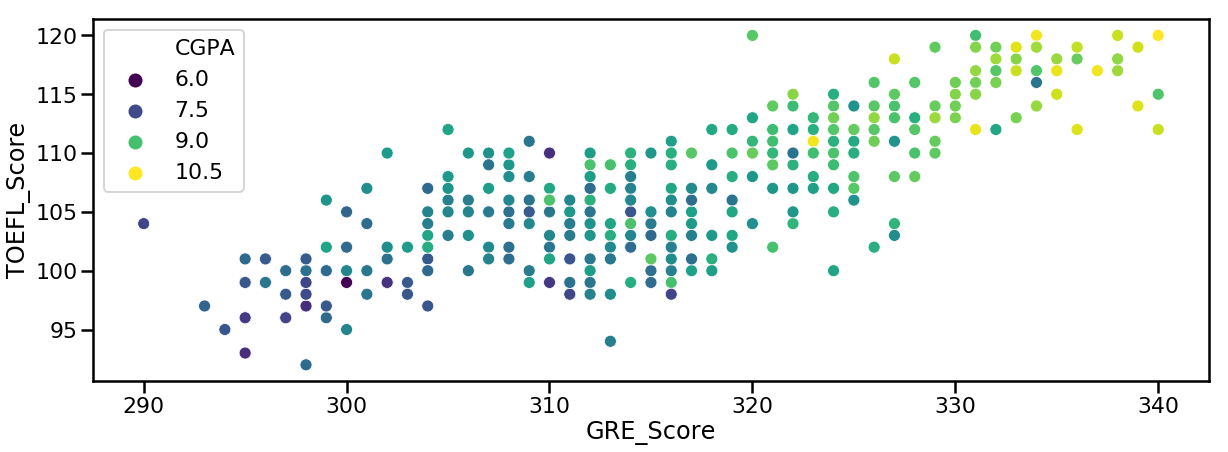

In [27]:
sns.set_context("poster")
fig = vz.get_scatter_GRE_TOEFL_GCPA(X_train, savefig=True,save_path='img/scatter_GRE_TOEFL_GCPA',context="poster")

#visually observing the correlation between GRE, TOEFL and GCPA

## Run regression

### sm formula OLS regression

Here we perform an OLS regression of all features in X, except research.  y_train is the target.

The qqplot at the bottom of the output shows relatively standard distribution of residuals.


formula: target~GRE_Score+TOEFL_Score+University_Rating+SOP+LOR+CGPA 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.813
Method:                 Least Squares   F-statistic:                     291.1
Date:                Thu, 12 Sep 2019   Prob (F-statistic):          3.26e-141
Time:                        12:37:54   Log-Likelihood:                 556.65
No. Observations:                 400   AIC:                            -1099.
Df Residuals:                     393   BIC:                            -1071.
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

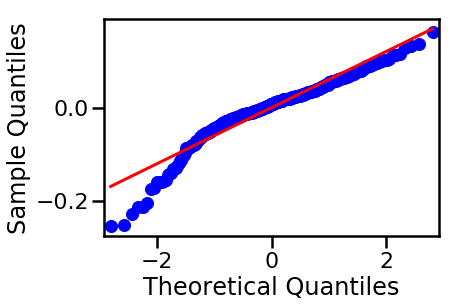

In [28]:
#sm formula OLS regression
model_sm_OLS = r.statsmodel_ols_formula_regression(X_train,
                                                   y_train,
                                                   show_resid=True,
                                                   qqplot_line='s',
                                                   print_resid=True,
                                                   resid_path='img/sm_ols_resid.png')
#OLS regression result shows us an R2 of 0.816
#residuals appear to be normally distrubtured in the qqplot

### SKlearn OLS

Same OLS model with SKlearn

In [29]:
#generate linear regression model with SKlearn
model_sk_learn = r.sklearn_ols_regression(
    X_train,y_train,print_coefficients=True,
    print_resid=True,
    plot_resid=False,
    qqplot_line='s'
)


Features:  ['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA']
Coefficients:  [[0.00302455 0.00286185 0.00369154 0.00204337 0.01732817 0.11269332]]
y-intercept:  [-1.587]


explained_variance:  0.8163
mean_squared_log_error:  0.0014
r2:  0.8163
MAE:  0.0431
MSE:  0.0036
RMSE:  0.0602




## Inverse transform of y

As we've seen above, the OLS residuals of a number of variables are not normally distributed. We will attempt to transform the target parameter to fix this.

In [36]:
y_inverse_transform = r.inverse_transform(y_train, ['Chance_of_Admit'])
# y_inverse_transform.shape
sk_model = r.sklearn_ols_regression(X_train,y_inverse_transform)
y_inverse_pred = sk_model.predict(X_train)
# y_inverse_pred

Features:  ['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA']
Coefficients:  [[-0.00703845 -0.00527203  0.00953972  0.0104983  -0.05357014 -0.27326369]]
y-intercept:  [6.705]




Regression r2 of 0.6717 is lower than without y_inverse_transform

In [37]:
r.regression_results(y_inverse_transform, y_inverse_pred)

explained_variance:  0.6717
mean_squared_log_error:  0.0048
r2:  0.6717
MAE:  0.1275
MSE:  0.0374
RMSE:  0.1933





formula: target~GRE_Score+TOEFL_Score+University_Rating+SOP+LOR+CGPA 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     134.0
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           8.10e-92
Time:                        12:43:04   Log-Likelihood:                 89.765
No. Observations:                 400   AIC:                            -165.5
Df Residuals:                     393   BIC:                            -137.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

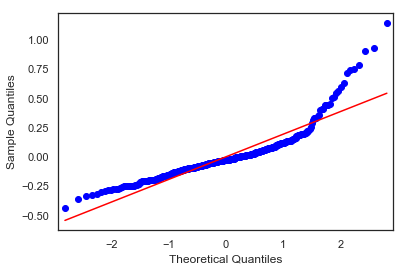

In [42]:
sns.set_context('notebook')
r.statsmodel_ols_formula_regression(X_train,y_inverse_transform,suppress=False,show_resid=True,qqplot_line='s')

Ran SM OLS to check SKlearn. Residuals may not be normally distrubuted


formula: target~GRE_Score+TOEFL_Score+University_Rating+SOP+LOR+CGPA 

                            OLS Regression Results                            
Dep. Variable:                 target   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     134.0
Date:                Thu, 12 Sep 2019   Prob (F-statistic):           8.10e-92
Time:                        12:41:01   Log-Likelihood:                 89.765
No. Observations:                 400   AIC:                            -165.5
Df Residuals:                     393   BIC:                            -137.6
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------

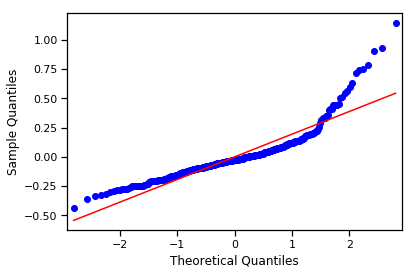

In [38]:
sns.set_context('notebook')
r.statsmodel_ols_formula_regression(X_train,y_inverse_transform,suppress=False,show_resid=True,qqplot_line='s')

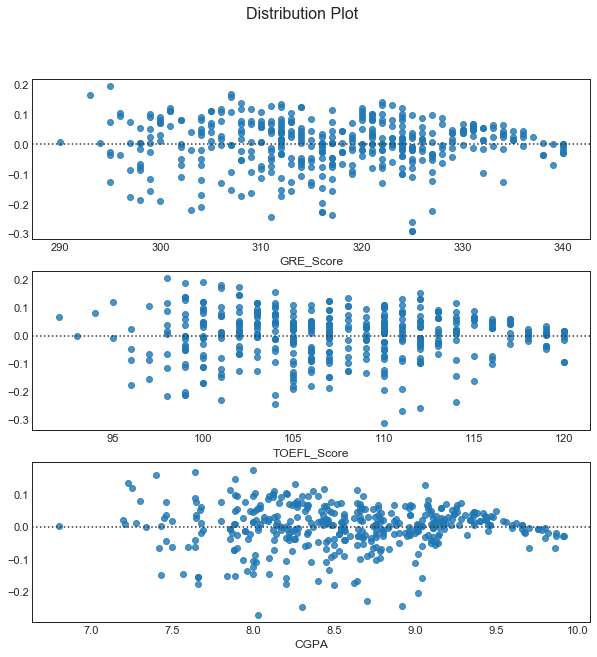

In [39]:
sns.set_context("notebook")
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
r.residual_plot(X_train,
                y_train,
                feature_list=['GRE_Score','TOEFL_Score','CGPA'],
                cols=1,
                savefig=True,
                save_path="img/distribution_plot_3__cont_features.png",
                title='Distribution Plot')

Here we attempt a log transform of the target variable

In [ ]:
y_log_trans = r.log_transform(y_train,features=y_train.columns)
sk_model = r.sklearn_ols_regression(X_train, y_log_trans, print_coefficients=True)
y_log_trans_pred = sk_model.predict(X_train)
r.regression_results(y_true= y_log_trans, y_pred= y_log_trans_pred)

In [ ]:
sns.set_context("notebook")
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
r.residual_plot(X_train,
                y_log_trans,
                feature_list=['GRE_Score','TOEFL_Score','CGPA'],
                cols=1,
                savefig=True,
                save_path="img/distribution_plot_3_logt_target.png")

We see that residuals for log transformed target parameter continues to not be normally distrubuted. We will need to dig further to understand that the drivers of the bias

## Lasso with higher degree features

Based on the pair-plot that we saw earlier on, we would like to create polynomial features. We will create polynomial features with degree 3 or less then use the lasso regression to select features from among the expanded set of features

In [47]:
#use a the polynomial transform SKlearn tool to get polynomial features
#features output as a list of np.arrays
X_Train_list = r.get_higher_order_list(X_train,degrees=3,verbose=False)
len(X_Train_list)

3

In [48]:
#create df of r2_test scores for combinations of degrees [1:3] and various alpha values
r2_test = m.lasso_test_scores(X_Train_list,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

We can see that a number of these scenarious have r2 values of about 0.81. The scenarios with the lowest alphas and higher order features have a better score. None of these are very different from our r2 results running OLS on the initial feature list.

In [49]:
r2_test.sort_values(by='r2',ascending=False).head(10)

,degrees,alpha,r2
20,3,0.0001,0.819290
0,1,0.0001,0.795057
10,2,0.0001,0.792539
11,2,0.0100,0.786820
1,1,0.0100,0.783546
21,3,0.0100,0.765001
12,2,0.1000,0.286711
22,3,0.1000,0.280302
2,1,0.1000,0.247742
25,3,2.0000,-0.002109


Here we see the lower end of r2 for the same dataset.

In [51]:
r2_test.sort_values(by='r2',ascending=True).head(5)

,degrees,alpha,r2
9,1,100.0,-0.029288
14,2,1.0,-0.027265
19,2,100.0,-0.025213
18,2,30.0,-0.024241
8,1,30.0,-0.024191


Here we see visually what was discussed previously - that r2_test is high only when alpha is high and / or when the degrees are low

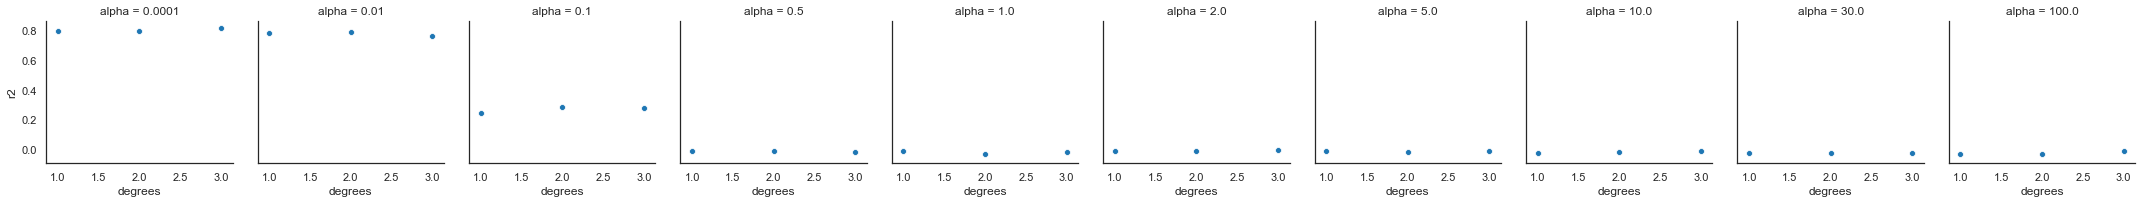

In [52]:
sns.set_context("notebook")
g = sns.FacetGrid(r2_test, col='alpha')
g.map(sns.scatterplot, 'degrees', 'r2')
plt.savefig('img/degrees_alpha_lasso.png')

## What if target is based on a logistic regression?
Original regression may have been run using logistic regression where:
set **y_logistic_transform** = $\ln(\frac{y}{y-1})$

Outcome: The variance of our residuals looks more normal; we still have some bias in the residuals which we can try to address with transformations to our features. We'll try a lasso with higher order features, next


In [43]:
y_train.head()

,Chance_of_Admit
249,0.77
433,0.71
19,0.62
322,0.72
332,0.75


In [44]:
y_train_logistic_transform = y_train.Chance_of_Admit.apply(lambda y: np.log(y/(1-y)))

In [40]:
y_inverse_transform = r.inverse_transform(y_train, ['Chance_of_Admit'])
# y_inverse_transform.shape
sk_model = r.sklearn_ols_regression(X_train,y_inverse_transform)
y_inverse_pred = sk_model.predict(X_train)
# y_inverse_pred

Features:  ['GRE_Score', 'TOEFL_Score', 'University_Rating', 'SOP', 'LOR', 'CGPA']
Coefficients:  [[-0.00703845 -0.00527203  0.00953972  0.0104983  -0.05357014 -0.27326369]]
y-intercept:  [6.705]




In [41]:
r.regression_results(y_inverse_transform, y_inverse_pred)

explained_variance:  0.6717
mean_squared_log_error:  0.0048
r2:  0.6717
MAE:  0.1275
MSE:  0.0374
RMSE:  0.1933




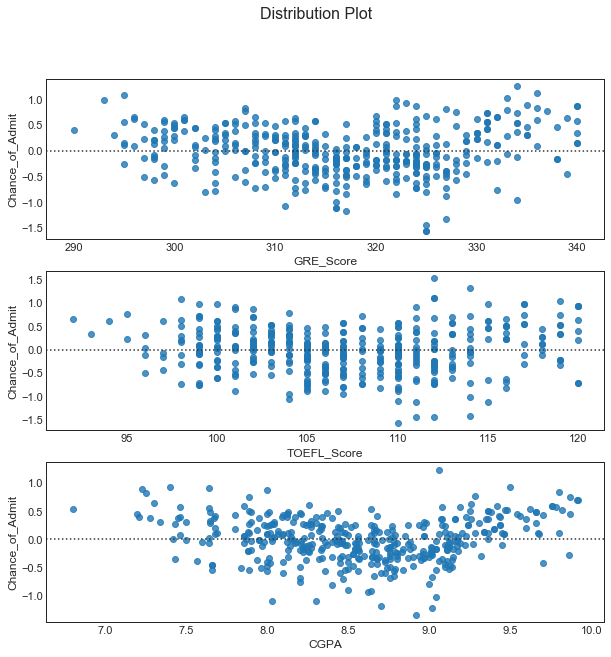

In [46]:
sns.set_context("notebook")
plt.style.use('seaborn-whitegrid')
sns.set_style("white")
r.residual_plot(X_train,
                y_train_logistic_transform,
                feature_list=['GRE_Score','TOEFL_Score','CGPA'],
                cols=1,
                savefig=True,
                save_path="img/distribution_plot_3__cont_features.png",
                title='Distribution Plot')

## Lasso with higher degree features (after transforming y)

Outcom: After transformation of the target, running lasso on higher order features does provide better r2

Our lowest alpha option (0.0001) still comes out the best which may be a red flag.  Further discussion required. For now, do not use this step.

In [54]:
#use a the polynomial transform SKlearn tool to get polynomial features
#features output as a list of np.arrays
X_Train_list = r.get_higher_order_list(X_train,degrees=3,verbose=False)
len(X_Train_list)

3

In [60]:
#create df of r2_test scores for combinations of degrees [1:3] and various alpha values
r2_test_y_logistic_transform = m.lasso_test_scores(X_Train_list,y_train_logistic_transform)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/coordinate_descent.py:492: ConvergenceWarning: Objective did not converge. You might want to increase the number of

In [61]:
r2_test_y_logistic_transform.sort_values(by='r2',ascending=False).head(10)

,degrees,alpha,r2
20,3,0.0001,0.874521
11,2,0.0100,0.872919
10,2,0.0001,0.859630
21,3,0.0100,0.856654
1,1,0.0100,0.836027
0,1,0.0001,0.832191
22,3,0.1000,0.813261
12,2,0.1000,0.812694
2,1,0.1000,0.796945
13,2,0.5000,0.474652


In [62]:
r2_test_y_logistic_transform.sort_values(by='r2',ascending=True).head(5)

,degrees,alpha,r2
5,1,2.0,-0.049833
26,3,5.0,-0.032895
6,1,5.0,-0.030675
24,3,1.0,-0.026781
17,2,10.0,-0.025414


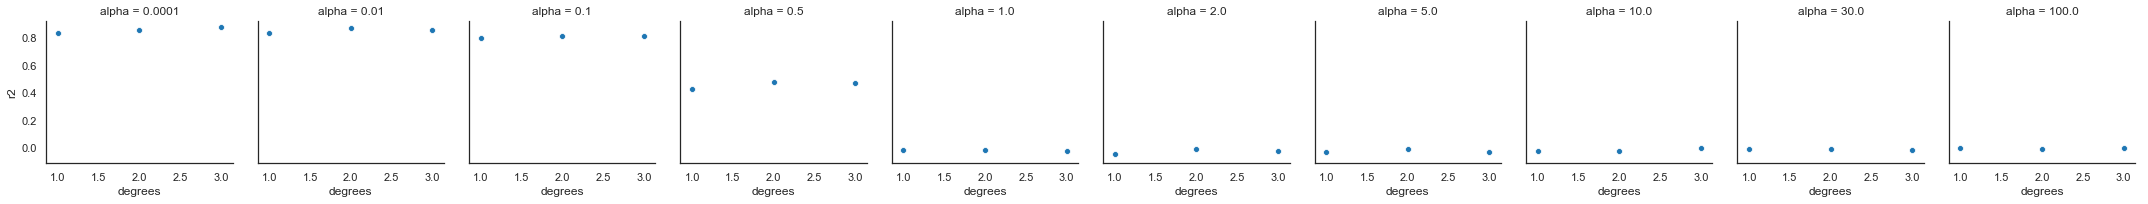

In [63]:
sns.set_context("notebook")
g = sns.FacetGrid(r2_test_y_logistic_transform, col='alpha')
g.map(sns.scatterplot, 'degrees', 'r2')
plt.savefig('img/degrees_alpha_lasso.png')